⚡ Loading cached features


C:\Users\ajayn\anaconda3\envs\py312env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['central_purch_blk_flag']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(



📊 Classification Report (Isolation Forest):
              precision    recall  f1-score   support

     No Risk       0.83      0.67      0.74     10906
       Fraud       0.42      0.63      0.50      4101

    accuracy                           0.66     15007
   macro avg       0.62      0.65      0.62     15007
weighted avg       0.71      0.66      0.67     15007



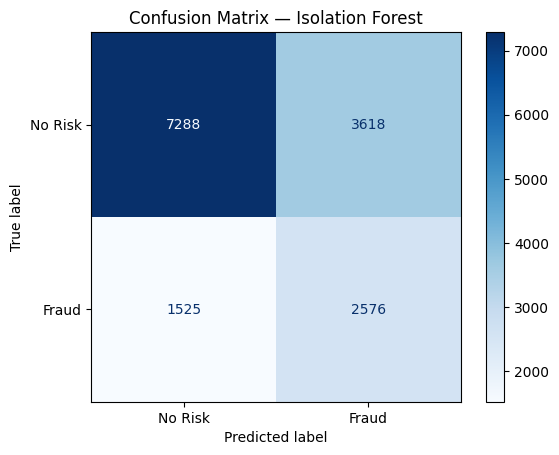

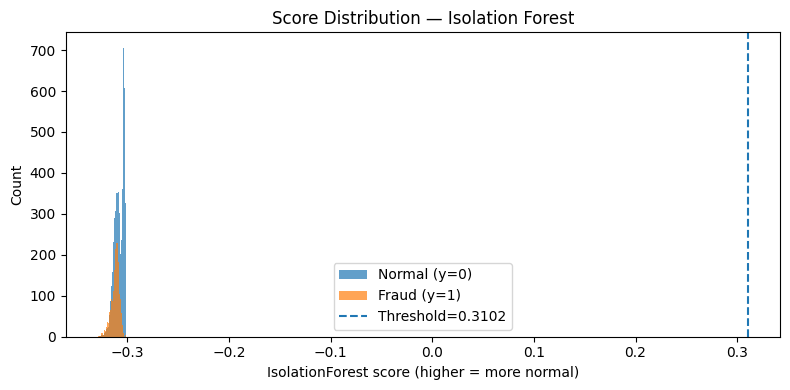


✅ Saved: po_iso_preprocessor_02_10.pkl, po_isoforest_model_02_10.pkl, po_isoforest_threshold_02_10.npy


In [2]:
from __future__ import annotations
##############################################################################
#  Cell 1 — Imports & common paths
##############################################################################
import os
import json
import pandas as pd
import numpy as np
import psycopg2
import joblib
import logging
from typing import List
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import LocalOutlierFactor
import logging
from sklearn.metrics import (
    r2_score,
    explained_variance_score,
    mean_absolute_error,
    mean_squared_error
)
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
from typing import Optional

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sys, os

# Ensure stdout uses UTF-8
try:
    sys.stdout.reconfigure(encoding="utf-8")
except Exception:
    os.environ["PYTHONIOENCODING"] = "utf-8"
# Set options to show full DataFrame output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import random
from pathlib import Path
from datetime import timedelta
import joblib, json, warnings
import numpy as np
import pandas as pd
import argparse
from typing import Any, Dict
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt




RAW_PO      = Path("po_data_02_10.pkl") #("../Po_Invoice_Data/po_output_tushar.pkl")      # raw PO data (input)
FEAT_PO     = Path("Po_Invoice_Data/po_output_features_df_auto_model_02_10.pkl")
# -------------------------
# Paths to persist artifacts
# -------------------------
ARTIFACT_DIR = Path("Po_Invoice_Data")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
PREPROC_PKL   = ARTIFACT_DIR / "po_iso_preprocessor_02_10.pkl"
MODEL_PKL     = ARTIFACT_DIR / "po_isoforest_model_02_10.pkl"
THRESHOLD_NPY = ARTIFACT_DIR / "po_isoforest_threshold_02_10.npy"
warnings.filterwarnings("ignore", category=FutureWarning)

def data_load_and_cleaning_po():
        ### setting connection
    #conn = psycopg2.connect(host='fortifai-ng-dev-db.postgres.database.azure.com',
    			#database='baldota-dev-db',
    			#user='fortifai_ng_ai_user_rw',
    			#password='AIPwd@123!',
    			#port='5432',
                #sslmode="require"
    		#)
    
    conn = psycopg2.connect(host='fortifai-ng-dev-db.postgres.database.azure.com',
    			database='baldota-dev-db',
    			user='fortifai_ng_user_ro',
    			password='user@123!',
    			port='5432',
                sslmode="require"
    		)
    cur = conn.cursor()
    cur.execute("""
                SELECT table_name 
                FROM information_schema.tables 
            """)
    tables = [row[0] for row in cur.fetchall()]
    
     # --- Step 4: Commit and close ---
    #conn.commit()
    #cur.close()
    #conn.close()
    
    line_item_keys = ["Purch.Doc.","Item", "Purch.Req.","Item.1",
        "Buyer Name", "Changed On", "CoCd", "Eq. To", "Denom.", "Conv.", "Conv..1", "Ct", "Customer", "D",
        "GR", "GR Date", "GR-IV", "Gross value", "IR","MTyp", "Material", "Matl Group",
        "Net Price", "Net Value", "PO Quantity.1", "PO Quantity", "Plnt",
        "Reference Document for PO Trac", "S", "Short Text", "Targ. Qty", "Target Value", "TrackingNo",
        "EKPO-CHG_FPLNR", "Acknowledgment", "Agmt.", "Item.2", "Status of purchasing doc. item"
    ]
    line_item_values = ["purch_doc_no", "purch_doc_item_no","pr_no", "pr_item_no",
        "requester_name", "doc_change_date", "company_code", "p2o_unit_conv_denom", "o2b_unit_conv_denom",
        "p2o_unit_conv_num", "o2b_unit_conv_num", "acct_assgnmt_category", "customer_no", "po_item_del_flag",
        "gr_indicator", "latest_gr_dt", "gr_invoice_verif_flag", "gross_val_po_curr", "inv_receipt_indicator",
        "material_type", "material_no", "matl_group", "net_price_doc_curr",
        "net_val_po_curr", "order_uom", "quantity", "plant", "tpop_crm_ref_ordr_no",
        "rfq_status", "short_text", "target_qty", "outline_agrmt_tgt_val_doc_curr", "reqmt_tracking_no",
        "no_invoice_flag", "order_ack_no", "principal_purch_agrmt_no", "principal_purch_agrmt_item_no",
        "purch_doc_item_status"
    ]
    
    
    # Step 2: Create the dictionary
    my_dict_line_item = dict(zip(line_item_keys, line_item_values))
    
    # Step 3: Print the result
    print("Line items key with baldota: mapped values SAP fixed",my_dict_line_item)
    
    header_keys=["Purch.Doc.","Supplier",
        "C", "CoCd", "Crcy", "Created By", "Created On", "Ctl", "D", "Doc. Date",
        "Doc.Cond.", "Exch. Rate", "PGr", "POrg", "PayT", "Proc.state",
        "R", "Rel", "Release", "S", "Salespers.", "Tot. value", "Type",
        "VP Start", "VPer.End"]
    header_values=["purch_doc_no","vendor_or_creditor_acct_no",
        "purch_doc_category", "company_code", "currency", "object_created_by", "doc_change_date",
        "control_indicator", "po_item_del_flag", "purch_doc_date", "principal_purch_agrmt_no",
        "exchange_rate", "purch_group", "purch_org", "pymnt_terms", "processing_status", "doc_release_incompl_flag", "release_indicator", "release_status",
        "rfq_status", "resp_vendor_salesperson",
        "on_release_total_value", "purch_doc_type", "validity_start_dt", "validity_end_dt"
    ]
    # Step 2: Create the dictionary
    my_header_dict = dict(zip(header_keys, header_values))
    
    # Step 3: Print the result
    print("Header key with baldota: mapped values SAP fixed",my_header_dict)
    
    
    
    
    #tables = [row[0] for row in cur.fetchall()]
    #p2p_line_item_po_data
    for table in tables:
        if table == 'purchasing_document_item':
            p2p_line_item_po_data= pd.read_sql_query(f"SELECT * FROM ingest_db.{table}", conn)
            
    df_line_item_po_data=p2p_line_item_po_data.copy()
    ## dropping '4500009180^00030' at index 0 as its order_uom is 0.0 must be added for testing
    df_line_item_po_data.drop(index=0, inplace=True)
    
    # convert to str to maintain
    df_line_item_po_data['purch_doc_no'] = df_line_item_po_data['purch_doc_no'].astype(float).astype('int64').astype(str)
    #df_line_item_po_data['pr_no'] = df_line_item_po_data['pr_no'].astype(float).astype('int64').astype(str)
    
    ### bring values for item number to orginal form, 10.0 to 00010 etc
    df_line_item_po_data['purch_doc_item_no'] = df_line_item_po_data['purch_doc_item_no'].fillna(0).astype(float).astype(int).astype(str).str.zfill(5)
    df_line_item_po_data['pr_item_no'] = df_line_item_po_data['pr_item_no'].fillna(0).astype(float).astype(int).astype(str).str.zfill(5)
    #df_line_item_po_data['principal_purch_agrmt_item_no'] = df_line_item_po_data['principal_purch_agrmt_item_no'].fillna(0).astype(float).astype(int).astype(str).str.zfill(5)
    
    ## converting all column values dtype to string except for ingestion_timestamp :: will be updating dtype for values in code when those are required
    #df_line_item_po_data.loc[:, df_line_item_po_data.columns != 'ingestion_timestamp'] = df_line_item_po_data.loc[:, df_line_item_po_data.columns != 'ingestion_timestamp'].astype(str)
    
    ##main data using the mapped columns from baldota
    df_line_item=df_line_item_po_data[line_item_values]
    ## to merge with label data later on
    df_line_item['base_id']=df_line_item["purch_doc_no"] + "^" + df_line_item["purch_doc_item_no"]
    # adding src to line item data columns to distinguish with header column data
    df_line_item_renamed = df_line_item.rename(columns={col: f"{col}_src" for col in df_line_item.columns})
    
    
    #p2p_header_po_data
    for table in tables:
        if table == 'purchasing_document_header':
            p2p_header_po_data= pd.read_sql_query(f"SELECT * FROM ingest_db.{table}", conn)
    df_header_po_data=p2p_header_po_data.copy()
    
    df_header_po_data['purch_doc_no'] = df_header_po_data['purch_doc_no'].astype(float).astype('int64').astype(str)
    ## converting all column values dtype to string except for ingestion_timestamp :: will be updating dtype for values in code when those are required
    #df_header_po_data.loc[:, df_header_po_data.columns != 'ingestion_timestamp'] = df_header_po_data.loc[:, df_header_po_data.columns != 'ingestion_timestamp'].astype(str)
    ##main data using the mapped columns from baldota
    df_header=df_header_po_data[header_values]
    # adding hpd to header data columns to distinguish with line_item column data
    df_header_renamed = df_header.rename(columns={col: f"{col}_hpd" for col in df_header.columns})
    
    merged_df_before_label=pd.merge(df_line_item_renamed,df_header_renamed,left_on='purch_doc_no_src',right_on='purch_doc_no_hpd',how='outer')
    merged_df_before_label.shape
    
    
    df=merged_df_before_label.copy()
    # Convert dates
    df["doc_change_date_src"] = pd.to_datetime(df["doc_change_date_src"], errors='coerce')
    df["doc_change_date_hpd"] = pd.to_datetime(df["doc_change_date_hpd"], errors='coerce')
    df["purch_doc_date_hpd"] = pd.to_datetime(df["purch_doc_date_hpd"], errors='coerce')
    
    # drop all rows where all values are Nan
    df = df.dropna(axis=1, how='all')
    #df.info()
    #df['purch_doc_mapping']=df["purch_doc_no_src"] + "^" + df["purch_doc_item_no_src"]
    df_final_po= df.rename(columns={col: f"{col}_po" for col in df.columns})
    df_final_po.info()
    cur.close()
    conn.close()
    # there are 3 po that have data in header but not in line item
    
    
    
    
    ### Invoice Data ####
    
    conn = psycopg2.connect(host='fortifai-ng-dev-db.postgres.database.azure.com',
    			database='baldota-dev-db',
    			user='fortifai_ng_user_ro',
    			password='user@123!',
    			port='5432',
                sslmode="require"
    		)
    cur = conn.cursor()
    cur.execute("""
                SELECT table_name 
                FROM information_schema.tables 
            """)
    tables = [row[0] for row in cur.fetchall()]
    
    
    line_item_keys = ["DocumentNo","InvItem","Purch.Doc.","Item", "Amount", "BlR", "Central Contract", "Central Contract Item", "CoCd", "D/C", "FIn",
        "GR/IR Clrg", "Indicator for Differential Invoicing", "Material", "Plnt",
         "OUn", "Quantity", "OPUn", "Qty in OPUn", "Reference", "SAA", "Supplier",
        "Tax Jur.", "Year", "Year.1"
    ]
    line_item_values = ["accounting_doc_no","doc_line_item_no","purch_doc_no", "purch_doc_item_no","amt_doc_curr", "block_reason_field", "central_contract",
                        "central_contract_item_no","company_code", "debit_credit_flag", "final_inv_flag",
        "ext_gr_ir_clrg_flag", "diff_invoicing_flag", 
        "material_no", "plant", "order_uom", "quantity", "po_uom",
        "po_qty_order_uom", "ref_doc_no", "acct_assgnmt_seq_no", "vendor_or_creditor_acct_no",
        "tax_jurisdiction_code", "fiscal_year", "ref_doc_fiscal_year"
    ]
    
    
    # Step 2: Create the dictionary
    my_dict_line_item = dict(zip(line_item_keys, line_item_values))
    
    # Step 3: Print the result
    print("Line items key with baldota: mapped values SAP fixed",my_dict_line_item)
    
    header_keys= ["Doc. No.",
        "Bline Date", "CoCd", "Crcy", "Del.Costs", "Doc. Date",  "Doc.Header Text",
        "Entry Dte", "Exch.rate", "G/L", "Gross Amnt", "I", "IV cat", "InR.Ref.no", "Inv. Pty",
        "PBk", "PM", "PayT", "Payer", "Paymt Ref.", "Reference", "Rel.", "Rvrsd by",
        "St", "TCode", "Time", "Type", "User Name"
    ]
    header_values=["accounting_doc_no","baseline_date", "company_code", "currency", "unplanned_dlvry_costs", "doc_date",
         "doc_header_text", "doc_entry_date", "exchange_rate", "gl_account",
        "gross_inv_amt_doc_curr", "post_inv_flag", "logistics_inv_verif_orig_type", "txn_invoice_no",
        "vendor_or_creditor_acct_no", "house_bank_short_key", "pymnt_method", "pymnt_terms",
        "payee_or_payer_name", "assignment_no", "ref_doc_no", "sap_release", "reversal_doc_no",
        "invoice_doc_status", "txn_code", "entry_time", "doc_type", "username"
    ]
    # Step 2: Create the dictionary
    my_header_dict = dict(zip(header_keys, header_values))
    
    # Step 3: Print the result
    print("Header key with baldota: mapped values SAP fixed",my_header_dict)
    
    
    #tables = [row[0] for row in cur.fetchall()]
    #p2p_line_item_invoice_data
    for table in tables:
        if table == 'invoice_receipt_items':
            p2p_line_item_invoice_data= pd.read_sql_query(f"SELECT * FROM ingest_db.{table}", conn)
            
    df_line_item_invoice_data=p2p_line_item_invoice_data.copy()
    # there are na values in accounting_doc_no--> dropping
    df_line_item_invoice_data= df_line_item_invoice_data.dropna(subset=['accounting_doc_no'])
    
    # convert to str to maintain
    df_line_item_invoice_data['accounting_doc_no'] = df_line_item_invoice_data['accounting_doc_no'].astype(float).astype('int64').astype(str)
    df_line_item_invoice_data['purch_doc_no'] = df_line_item_invoice_data['purch_doc_no'].astype(float).astype('int64').astype(str)
    
    ### bring values for item number to orginal form, 10.0 to 00010 etc
    df_line_item_invoice_data['purch_doc_item_no'] = df_line_item_invoice_data['purch_doc_item_no'].fillna(0).astype(float).astype(int).astype(str).str.zfill(5)
    # convert doc_line_item_no to str
    df_line_item_invoice_data['doc_line_item_no'] = df_line_item_invoice_data['doc_line_item_no'].fillna(0).astype(float).astype(int).astype(str)
    
    
    
    ##main data using the mapped columns from baldota
    df_line_item=df_line_item_invoice_data[line_item_values]
    ## to merge with label data later on
    df_line_item['base_id']=df_line_item["accounting_doc_no"] + "^" + df_line_item["doc_line_item_no"]
    # adding src to line item data columns to distinguish with header column data
    df_line_item_renamed = df_line_item.rename(columns={col: f"{col}_src" for col in df_line_item.columns})
    
    
    #p2p_header_invoice_data
    for table in tables:
        if table == 'invoice_receipt_header':
            p2p_header_invoice_data= pd.read_sql_query(f"SELECT * FROM ingest_db.{table}", conn)
    df_header_invoice_data=p2p_header_invoice_data.copy()
    
    # there are na values in accounting_doc_no--> dropping
    df_header_invoice_data= df_header_invoice_data.dropna(subset=['accounting_doc_no'])
    
    # str maintain
    df_header_invoice_data['accounting_doc_no'] = df_header_invoice_data['accounting_doc_no'].astype(float).astype('int64').astype(str)
    ## converting all column values dtype to string except for ingestion_timestamp :: will be updating dtype for values in code when those are required
    #df_header_po_data.loc[:, df_header_po_data.columns != 'ingestion_timestamp'] = df_header_po_data.loc[:, df_header_po_data.columns != 'ingestion_timestamp'].astype(str)
    ##main data using the mapped columns from baldota
    df_header=df_header_invoice_data[header_values]
    # adding hpd to header data columns to distinguish with line_item column data
    df_header_renamed = df_header.rename(columns={col: f"{col}_hpd" for col in df_header.columns})
    
    merged_df_before_label=pd.merge(df_line_item_renamed,df_header_renamed,left_on='accounting_doc_no_src',right_on='accounting_doc_no_hpd',how='outer')
    merged_df_before_label.shape
    
    df=merged_df_before_label.copy()
    # Convert dates
    df["baseline_date_hpd"] = pd.to_datetime(df["baseline_date_hpd"], errors='coerce')
    df["doc_date_hpd"] = pd.to_datetime(df["doc_date_hpd"], errors='coerce')
    df["doc_entry_date_hpd"] = pd.to_datetime(df["doc_entry_date_hpd"], errors='coerce')
    
    # drop all rows where all values are Nan
    df = df.dropna(axis=1, how='all')
    #df.info()
    df['purch_doc_mapping']=df["purch_doc_no_src"] + "^" + df["purch_doc_item_no_src"]
    df_final_invoice = df.rename(columns={col: f"{col}_invoice" for col in df.columns})
    df_final_invoice.info()
    
    ## there are 175 invoice that have data in header but not in line item
    cur.close()
    conn.close()
    
    
    po_invoice=pd.merge(df_final_po,df_final_invoice, left_on='base_id_src_po',right_on='purch_doc_mapping_invoice',how='outer')
    
    ## cleaning .0 from vendor
    s = po_invoice['vendor_or_creditor_acct_no_hpd_po'].astype(str).str.strip()           # ensure string & tidy spaces
    mask = s.str.upper().eq('UNKNOWN')                 # rows to leave as-is
    po_invoice['vendor_or_creditor_acct_no_hpd_po'] = s.where(mask, s.str.replace(r'\.0$', '', regex=True))
    
    ## getting vendor name from vendor master DB
    conn = psycopg2.connect(host='fortifai-ng-dev-db.postgres.database.azure.com',
    			database='baldota-dev-db',
    			user='fortifai_ng_user_ro',
    			password='user@123!',
    			port='5432',
                sslmode="require"
    		)
    cur = conn.cursor()
    cur.execute("""
                SELECT table_name 
                FROM information_schema.tables 
            """)
    tables = [row[0] for row in cur.fetchall()]
    vendor_data= pd.read_sql_query(f"SELECT * FROM ingest_db.{'vendor_master_general_section'}", conn)
    lfa_1=pd.read_excel('LFA1 - Vendor Master.xlsx')
    lfa_1["Supplier"] = lfa_1["Supplier"].astype(str)
    lfa_1_1=lfa_1[['Supplier','DelF','DeBl','B','B.1','Status']]
    lfa_1_2 = lfa_1_1.rename(columns={
        "Supplier": "vendor_or_creditor_acct_no",
        'DelF':"central_deletion_flag",
        "DeBl": "central_del_block_flg",
        "B": "central_posting_blk_flag",
        "B.1": "central_purch_blk_flag",
        "Status": "data_transfer_status",
    })
    
    KEY = "vendor_or_creditor_acct_no"
    cols_to_update = ["central_deletion_flag",
        "central_del_block_flg",
        "central_posting_blk_flag",
        "central_purch_blk_flag",
        "data_transfer_status",
    ]
    
    
    vendor= vendor_data.drop(columns=cols_to_update)
    
    
    # Merge and overwrite columns
    merged = vendor.merge(
        lfa_1_2,
        on=KEY,
        how="outer")
    vendor_data_updated = merged
    # drop all rows where all values are Nan
    vendor_data_1 = vendor_data_updated.dropna(axis=1, how='all')
    po_invoice_vendor=pd.merge(po_invoice,vendor_data_1,left_on='vendor_or_creditor_acct_no_hpd_po',right_on='vendor_or_creditor_acct_no',how='outer')
    
   # ---------- 0) Invoice reversed flag ----------
    po_invoice_vendor["invoice_reversed"] = np.where(
        po_invoice_vendor["reversal_doc_no_hpd_invoice"].isnull(), 0, 1
    )
    
    # ---------- 1) Make sure inputs are numeric ----------
    for col in ["amt_doc_curr_src_invoice", "quantity_src_invoice",
                "net_val_po_curr_src_po", "quantity_src_po"]:
        po_invoice_vendor[col] = pd.to_numeric(po_invoice_vendor[col], errors="coerce")
    
    # ---------- 2) Build the gate ----------
    if "reversal_doc_no_hpd_invoice" in po_invoice_vendor.columns:
        inv_rev_ok = po_invoice_vendor["reversal_doc_no_hpd_invoice"].isna()
    elif "invoice_reversed" in po_invoice_vendor.columns:
        inv_rev_ok = po_invoice_vendor["invoice_reversed"].fillna(0).eq(0)
    else:
        inv_rev_ok = True  # broadcasts
    
    gate = (
        (po_invoice_vendor["release_indicator_hpd_po"] == "R") &
        (po_invoice_vendor["po_item_del_flag_src_po"].isna()) &
        inv_rev_ok
    )
    
    KEY = "purch_doc_mapping_invoice"
    
    # ---------- 3) Work only on gated rows ----------
    cols_needed = [KEY, "amt_doc_curr_src_invoice", "quantity_src_invoice",
                   "net_val_po_curr_src_po", "quantity_src_po"]
    gated = po_invoice_vendor.loc[gate, cols_needed].copy()
    
    # Group totals ONLY from gated rows
    gated["invoice_total_amount"]   = gated.groupby(KEY)["amt_doc_curr_src_invoice"].transform("sum")
    gated["invoice_total_quantity"] = gated.groupby(KEY)["quantity_src_invoice"].transform("sum")
    
    # Pick PO references within gated rows (use max to be conservative)
    gated["po_value_ref"] = gated.groupby(KEY)["net_val_po_curr_src_po"].transform("max")
    gated["po_qty_ref"]   = gated.groupby(KEY)["quantity_src_po"].transform("max")
    
    # ---------- 4) Kill float noise and compare with tolerance ----------
    AMT_ATOL = 0.01   # ₹0.01 tolerance
    QTY_ATOL = 1e-9   # effectively exact for integers
    
    # Round values before comparing (money: 2dp; qty: 6dp)
    gated["invoice_total_amount"]   = gated["invoice_total_amount"].round(2)
    gated["po_value_ref"]           = gated["po_value_ref"].round(2)
    gated["invoice_total_quantity"] = gated["invoice_total_quantity"].round(6)
    gated["po_qty_ref"]             = gated["po_qty_ref"].round(6)
    
    amt_breach = gated["invoice_total_amount"]   > (gated["po_value_ref"] + AMT_ATOL)
    qty_breach = gated["invoice_total_quantity"] > (gated["po_qty_ref"]   + QTY_ATOL)
    
    gated["invoice_more_than_po_flag"] = (amt_breach | qty_breach).astype(int)
    
    # If any row in a gated group breaches → mark ALL gated rows in that group
    gated["invoice_more_than_po_flag"] = gated.groupby(KEY)["invoice_more_than_po_flag"].transform("max")
    
    # ---------- 5) Map results back; non-gated rows remain 0 ----------
    po_invoice_vendor["invoice_total_amount"]          = 0.0
    po_invoice_vendor["invoice_total_quantity"]        = 0.0
    po_invoice_vendor["invoice_more_than_po_flag"]     = 0
    
    po_invoice_vendor.loc[gated.index, "invoice_total_amount"]   = gated["invoice_total_amount"].values
    po_invoice_vendor.loc[gated.index, "invoice_total_quantity"] = gated["invoice_total_quantity"].values
    po_invoice_vendor.loc[gated.index, "invoice_more_than_po_flag"] = gated["invoice_more_than_po_flag"].values
    
    # (Optional) ensure the flag is int, not float
    #po_invoice_vendor["invoice_more_than_po_flag"] = po_invoice_vendor["invoice_more_than_po_flag"].astype(int)
    
    
    
    label_data=pd.read_excel("Rulewise summary - 6 rules.xlsx")
    one=pd.merge(po_invoice_vendor,label_data,left_on='base_id_src_po',right_on='base_id',how='left')
    
    
    
    one_1=one[['purch_doc_no_src_po', 'purch_doc_item_no_src_po', 'pr_no_src_po',
           'pr_item_no_src_po', 'requester_name_src_po', 'doc_change_date_src_po',
           'company_code_src_po', 'p2o_unit_conv_denom_src_po',
           'o2b_unit_conv_denom_src_po', 'p2o_unit_conv_num_src_po',
           'o2b_unit_conv_num_src_po', 'po_item_del_flag_src_po',
           'gr_indicator_src_po', 'gr_invoice_verif_flag_src_po',
           'gross_val_po_curr_src_po', 'inv_receipt_indicator_src_po',
           'material_type_src_po', 'material_no_src_po', 'matl_group_src_po',
           'net_price_doc_curr_src_po', 'net_val_po_curr_src_po',
           'order_uom_src_po', 'quantity_src_po', 'plant_src_po',
           'short_text_src_po', 'target_qty_src_po',
           'outline_agrmt_tgt_val_doc_curr_src_po', 'reqmt_tracking_no_src_po',
           'principal_purch_agrmt_item_no_src_po', 'base_id_src_po',
           'purch_doc_no_hpd_po', 'vendor_or_creditor_acct_no_hpd_po',
           'purch_doc_category_hpd_po', 'company_code_hpd_po', 'currency_hpd_po',
           'object_created_by_hpd_po', 'doc_change_date_hpd_po',
           'control_indicator_hpd_po', 'purch_doc_date_hpd_po',
           'principal_purch_agrmt_no_hpd_po', 'exchange_rate_hpd_po',
           'purch_group_hpd_po', 'purch_org_hpd_po', 'pymnt_terms_hpd_po',
           'processing_status_hpd_po', 'doc_release_incompl_flag_hpd_po',
           'release_indicator_hpd_po', 'release_status_hpd_po',
           'rfq_status_hpd_po', 'resp_vendor_salesperson_hpd_po',
           'on_release_total_value_hpd_po', 'purch_doc_type_hpd_po','vendor_or_creditor_acct_no', 'country_code', 'vendor_name_1',
           'vendor_name_2', 'vendor_name_3', 'vendor_name_4', 'city',
           'postal_code', 'street_address', 'item_manual_addr_no',
           'matchcode_search_term_1', 'record_creation_dt', 'object_created_by',
           'vendor_acct_group',
           'tax_no_1', 'vendor_telephone_no', 'second_telephone_no', 'tax_no_3',
           'tax_no_5','central_deletion_flag', 'central_purch_blk_flag','central_posting_blk_flag','data_transfer_status',
               "invoice_more_than_po_flag"]]
    
    #one_1.drop_duplicates(inplace=True)
    
    #rule_2
    # ensure the flag is numeric 0/1 (or numeric)
    one_1["invoice_more_than_po_flag"] = (
        pd.to_numeric(one_1["invoice_more_than_po_flag"], errors="coerce")
          .fillna(0).astype(int)
    )
    
    # keep rows where the flag equals the group's max; drop the rest
    grp_max = one_1.groupby("base_id_src_po")["invoice_more_than_po_flag"].transform("max")
    one_1 = one_1.loc[
        one_1["invoice_more_than_po_flag"].eq(grp_max)
    ].copy()
    one_1 = (one_1
             .sort_values(["base_id_src_po", "invoice_more_than_po_flag"], ascending=[True, False])
             .drop_duplicates("base_id_src_po", keep="first"))
    
    
    # rule label output
    #line_item=pd.read_excel("baldota rule label data/Line Item Transaction Summary.xlsx")
    rft=pd.read_csv(r"C:\Users\ajayn\Downloads\FortifAI_NEW\Codes\New Codes\Model pipeline\08-07-25\13-07-2025\ML Codes\baldota rule label data\Line Item Transaction Summary 24_07.csv")
    ## taking output po label at line item
    rft_po=rft[rft['stage']=='PO']
    one_2=one_1[one_1['base_id_src_po'].notna()].copy()
    ## merging main data df with label data df
    one_3=pd.merge(one_2,rft_po[['base_id','rule_ids','rft_by_engine']],left_on='base_id_src_po',right_on='base_id',how="left")
    #one_3.head()
    ## rule_3
    block_cols = ["central_deletion_flag", "central_purch_blk_flag", "central_posting_blk_flag"]
    
    one_3["po_to_blocked_vendor"] = np.where(
        (one_3[block_cols].eq("X").any(axis=1)) &
        (one_3["release_indicator_hpd_po"] == "R") &
        (one_3["po_item_del_flag_src_po"].isna()),
        1,
        0
    )
    
    
    ## rule_4
    # Ensure both columns are datetime
    one_3["purch_doc_date_hpd_po"] = pd.to_datetime(one_3["purch_doc_date_hpd_po"], errors="coerce")
    one_3["record_creation_dt"] = pd.to_datetime(one_3["record_creation_dt"], errors="coerce")
    
    # Create flag: 1 if purch_doc_date_hpd_po is within 30 days of record_creation_dt
    one_3["purch_doc_within_30days"] = (
        (one_3["purch_doc_date_hpd_po"] - one_3["record_creation_dt"]).abs().dt.days <= 30
    ).astype(int)
    
    
    # Ensure numeric types
    one_3["on_release_total_value_hpd_po"] = pd.to_numeric(one_3["on_release_total_value_hpd_po"], errors="coerce")
    one_3["exchange_rate_hpd_po"] = pd.to_numeric(one_3["exchange_rate_hpd_po"], errors="coerce")
    
    # Calculate PO value in INR (or base currency)
    one_3["po_value_inr"] = one_3["on_release_total_value_hpd_po"] * one_3["exchange_rate_hpd_po"]
    
    # Create flag: 1 if > 1 crore (1 Cr = 10,000,000)
    one_3["po_gt_1cr_flag"] = np.where(one_3["po_value_inr"] > 1e7, 1, 0)
    
    one_3["po_to_new_vendor_gt_tolerance"] = np.where(
        (one_3["purch_doc_within_30days"] == 1) & (one_3["po_gt_1cr_flag"] == 1) & (one_3["release_indicator_hpd_po"] == 'R')
        & (one_3["po_item_del_flag_src_po"].isna()),
        1,
        0
    )
    ## rule_5
    df = one_3.copy() # or your dataframe name
    
    # 1) Extract PAN: remove first 2 chars and last 3 chars, clean up casing/whitespace
    df["pan_extracted"] = (
        df["tax_no_3"]
          .astype(str)
          .str.strip()
          .str.upper()
          .str[2:-3]                 # remove first 2 and last 3
    )
    
    # (Optional) Keep only plausible PANs (10 chars, alphanumeric)
    pan_valid = df["pan_extracted"].str.len().eq(10) & df["pan_extracted"].str.isalnum()
    df.loc[~pan_valid, "pan_extracted"] = np.nan
    
    # 2) Amount in INR (or base) and >= 1 Cr flag
    df["on_release_total_value_hpd_po"] = pd.to_numeric(df["on_release_total_value_hpd_po"], errors="coerce")
    df["exchange_rate_hpd_po"] = pd.to_numeric(df["exchange_rate_hpd_po"], errors="coerce")
    df["po_value_inr"] = df["on_release_total_value_hpd_po"] * df["exchange_rate_hpd_po"]
    
    amount_ge_1cr = df["po_value_inr"] >= 1e7  # 1 crore = 10,000,000
    
    # 3) 4th PAN character == 'P'
    fourth_char_is_P = df["pan_extracted"].str[3].eq("P")
    
    # 4) Final flag: 4th PAN char 'P' AND amount ≥ 1 Cr  -> 1 else 0
    df["pan4P_amt_ge_1cr_flag"] = np.where(fourth_char_is_P & amount_ge_1cr &  (df["release_indicator_hpd_po"] == 'R')
        & (df["po_item_del_flag_src_po"].isna()), 1, 0)
    
    ##rule_6
    df["missing_tax_id_flag"] = np.where(df["tax_no_3"].isna() &  (df["release_indicator_hpd_po"] == 'R')
        & (df["po_item_del_flag_src_po"].isna()), 1, 0)
    
    
    one_3=df.copy()
    
    
    
    # 1) Flag: True if either column is true
    # List your 5 columns
    cols_to_check = ["invoice_more_than_po_flag", "po_to_blocked_vendor", "po_to_new_vendor_gt_tolerance", "pan4P_amt_ge_1cr_flag","missing_tax_id_flag"]
    
    # output_flag will be True if any column == 1, else False
    one_3["new_model_output"] = df[cols_to_check].eq(1).any(axis=1)
    
    
    
    # List the columns to check
    cols_to_check = ["invoice_more_than_po_flag", "po_to_blocked_vendor", "po_to_new_vendor_gt_tolerance", "pan4P_amt_ge_1cr_flag","missing_tax_id_flag"]
    
    # Build rule_summary by joining column names where value == 1
    one_3["new_rule_summary"] = (
        df[cols_to_check]
        .apply(lambda row: ",".join(row.index[row.eq(1)]), axis=1)
    )
    
    # If you prefer NaN instead of empty string when no rules matched:
    # df["rule_summary"] = df["rule_summary"].replace("", np.nan)
    #one_3.head()
    
    
    
    try:
        to_bool
    except NameError:
        TRUEY = {"true","t","yes","y","1","ok","on"}
        def to_bool(x):
            if pd.isna(x):
                return False
            if isinstance(x, (bool, np.bool_)):
                return bool(x)
            if isinstance(x, (int, np.integer, float, np.floating)):
                # treat 1 or True-like as True
                return x == 1 or x is True
            return str(x).strip().lower() in TRUEY
    
    try:
        split_rules
    except NameError:
        def split_rules(val):
            if pd.isna(val):
                return []
            if isinstance(val, (list, tuple, set)):
                parts = list(val)
            else:
                # accept commas/semicolons
                parts = [p.strip() for chunk in str(val).split(';') for p in chunk.split(',')]
            parts = [p for p in parts if p and p.lower() != "nan"]
            # de-dupe preserve order
            seen, out = set(), []
            for p in parts:
                if p not in seen:
                    seen.add(p); out.append(p)
            return out
    
    
    
    # 1) Flag: True if either column is true
    one_3["rft_by_engine_7"] = (
        one_3["rft_by_engine"].map(to_bool) | one_3["new_model_output"].map(to_bool)
    )
    
    # (Optional) whitelist to avoid free-text becoming a "rule"
    ALLOWED_RULES = None  # e.g., {"invoice_before_po_flag", "invoice_more_than_po_flag"}
    
    def merge_rules_guarded(row):
        # Build candidate rules from both columns
        parts = split_rules(row.get("new_rule_summary")) + split_rules(row.get("rule_ids"))
        parts = list(dict.fromkeys(parts))  # de-dupe, keep order
        if ALLOWED_RULES is not None:
            parts = [p for p in parts if p in ALLOWED_RULES]
    
        # ENFORCE: if flag is False -> no rules
        if not to_bool(row.get("rft_by_engine_7", False)):
            return []
    
        return parts
    
    # Build final columns with gating
    one_3["rule_ids_7_list"] = one_3.apply(merge_rules_guarded, axis=1)
    one_3["rule_ids_7"] = one_3["rule_ids_7_list"].apply(lambda lst: ",".join(lst) if lst else np.nan)
    
    
    # Step 1: Get unique rule IDs from all rows (comma-separated strings)
    rule_sets = one_3['rule_ids_7'].dropna().apply(lambda x: [r.strip() for r in x.split(',')])
    unique_rules = sorted(set(r for sublist in rule_sets for r in sublist))
    
    # Step 2: Create columns for each rule ID with 1 if present, else 0
    for rule in unique_rules:
        one_3[rule] = one_3['rule_ids_7'].apply(lambda x: int(rule in x.split(',')) if pd.notna(x) else 0)
    
    #Invoice before PO date
    #Invoice Exceeds PO
    # Final rule to sub-risk mapping
    def get_sub_risks(row):
        rule_to_subrisk = {"P2P02067": "Price Variance Risk",
            "P2P02068": "Price Variance Risk",
            "P2P02070": "Split PO",
            "P2P02072": "Split PO",
            "invoice_more_than_po_flag": "Invoice Exceeds PO",
            "po_to_blocked_vendor":"PO to block vendor",
            "po_to_new_vendor_gt_tolerance":"PO to new vendor > tolerance level",
            "pan4P_amt_ge_1cr_flag":"PO to Non Company Vendors",
            "missing_tax_id_flag":"PO to Vendor with missing KYC",
                           
                           
            #rule_1": "Invoice before PO date",
        }
        risks = {rule_to_subrisk[rule] for rule in rule_to_subrisk if row.get(rule, 0) == 1}
        return list(risks) if risks else ["No Risk"]
    def sub_risk(df):    
        
        # Step 1: Assign Main Risk Scenario
        df["main_risk_scenario"] = df["rft_by_engine_7"].apply(
            lambda x: "Procurement Risk" if x else "No Risk"
        )
        
        # Step 2: Generate clean list of sub risks
        #def get_sub_risks(row):
            #risks = {rule_to_subrisk[rule] for rule in rule_to_subrisk if row.get(rule, 0) == 1}
            #return list(risks) if risks else ["No Risk"]
        
        df["sub_risks"] = df.apply(get_sub_risks, axis=1)
        
        return df
    
    invoice_data_2=sub_risk(one_3)
    #invoice_data_2.head()
    
    
    
    po_data_2=invoice_data_2[['purch_doc_no_src_po', 'purch_doc_item_no_src_po', 'pr_no_src_po',
           'pr_item_no_src_po', 'requester_name_src_po', 'doc_change_date_src_po',
           'company_code_src_po', 'p2o_unit_conv_denom_src_po',
           'o2b_unit_conv_denom_src_po', 'p2o_unit_conv_num_src_po',
           'o2b_unit_conv_num_src_po', 'po_item_del_flag_src_po',
           'gr_indicator_src_po', 'gr_invoice_verif_flag_src_po',
           'gross_val_po_curr_src_po', 'inv_receipt_indicator_src_po',
           'material_type_src_po', 'material_no_src_po', 'matl_group_src_po',
           'net_price_doc_curr_src_po', 'net_val_po_curr_src_po',
           'order_uom_src_po', 'quantity_src_po', 'plant_src_po',
           'short_text_src_po', 'target_qty_src_po',
           'outline_agrmt_tgt_val_doc_curr_src_po', 'reqmt_tracking_no_src_po',
           'principal_purch_agrmt_item_no_src_po', 'base_id_src_po',
           'purch_doc_no_hpd_po', 'vendor_or_creditor_acct_no_hpd_po',
           'purch_doc_category_hpd_po', 'company_code_hpd_po', 'currency_hpd_po',
           'object_created_by_hpd_po', 'doc_change_date_hpd_po',
           'control_indicator_hpd_po', 'purch_doc_date_hpd_po',
           'principal_purch_agrmt_no_hpd_po', 'exchange_rate_hpd_po',
           'purch_group_hpd_po', 'purch_org_hpd_po', 'pymnt_terms_hpd_po',
           'processing_status_hpd_po', 'doc_release_incompl_flag_hpd_po',
           'release_indicator_hpd_po', 'release_status_hpd_po',
           'rfq_status_hpd_po', 'resp_vendor_salesperson_hpd_po',
                                  'on_release_total_value_hpd_po', 'purch_doc_type_hpd_po',
           'vendor_or_creditor_acct_no', 'country_code', 'vendor_name_1',
           'vendor_name_2', 'vendor_name_3', 'vendor_name_4', 'city',
           'postal_code', 'street_address', 'item_manual_addr_no',
           'matchcode_search_term_1', 'record_creation_dt', 'object_created_by',
           'vendor_acct_group', 'tax_no_1', 'vendor_telephone_no',
           'second_telephone_no', 'tax_no_3', 'tax_no_5', 'central_deletion_flag',
           'central_purch_blk_flag', 'central_posting_blk_flag',
           'data_transfer_status', 'invoice_more_than_po_flag', 
           'po_to_blocked_vendor', 'purch_doc_within_30days', 'po_value_inr',
           'po_gt_1cr_flag', 'po_to_new_vendor_gt_tolerance', 'pan_extracted',
           'pan4P_amt_ge_1cr_flag', 'missing_tax_id_flag','rft_by_engine_7','main_risk_scenario', 'sub_risks']]
    
    #po_data_2.head()po_invoice
    #po_data_2.to_pickle('po_data_02_10.pkl')
    return po_data_2


COL_MAP: Dict[str, str] = {
    # raw_column                          # internal name
    "vendor_or_creditor_acct_no_hpd_po": "vendor_id",
    "material_no_src_po": "material_id",
    "purch_doc_date_hpd_po": "po_date",
    "doc_change_date_src_po": "po_change_date",
    "net_price_doc_curr_src_po": "net_price",
    "gross_val_po_curr_src_po": "gross_val",
    "exchange_rate_hpd_po": "exch_rate",
    "requester_name_src_po": "requester",
    # unit‑conversion numerators / denominators
    "p2o_unit_conv_num_src_po": "p2o_num",
    "p2o_unit_conv_denom_src_po": "p2o_den",
    "o2b_unit_conv_num_src_po": "o2b_num",
    "o2b_unit_conv_denom_src_po": "o2b_den",
}

# -----------------------------------------------------------------------------
# 2) Feature engineering functions (pure, chainable)
# -----------------------------------------------------------------------------

def _prep(df: pd.DataFrame) -> pd.DataFrame:
    """Rename key columns, parse dates & fill obvious nulls."""
    #df = df.rename(columns={k: v for k, v in COL_MAP.items() if k in df.columns})
    df["purch_doc_date_hpd_po"] = pd.to_datetime(df["purch_doc_date_hpd_po"], errors="coerce")
    df["doc_change_date_src_po"] = pd.to_datetime(df.get("doc_change_date_src_po"), errors="coerce")
    df["vendor_or_creditor_acct_no_hpd_po"] = df.get("vendor_or_creditor_acct_no_hpd_po", "UNKNOWN").fillna("UNKNOWN")
    df["requester_name_src_po"] = df.get("requester_name_src_po", "UNKNOWN").fillna("UNKNOWN")
    df["exchange_rate_hpd_po"] = df.get("exchange_rate_hpd_po", 1.0).replace({0: np.nan}).fillna(1.0)
    return df

# -----------------------------------------------------------------------------
# 2a) Rule‑based features (rules 1,2,3,5)
# -----------------------------------------------------------------------------

def add_rule_metrics(df: pd.DataFrame,
                     split_days: int = 60,
                     price_var_days: int = 365) -> pd.DataFrame:
    """Add features mirroring Baldota P2P rules.

    * vm_count/value = aggregation for **same vendor+material** within *split_days*
    * vm_price_var_pct = price deviation (%) vs mean of past *price_var_days*
    * mat_vendor_cnt & mat_price_var_pct analogues for material across vendors
    """
    df = df.copy()
    df.sort_values("purch_doc_date_hpd_po", inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Initialise
    df["vm_count_%dd" % split_days] = 0
    df["vm_value_%dd" % split_days] = 0.0
    df["vm_price_var_pct_%dd" % price_var_days] = 0.0
    df["mat_vendor_cnt_%dd" % split_days] = 0
    df["mat_price_var_pct_%dd" % price_var_days] = 0.0

    # Pre‑extract convenient arrays for speed
    po_dates = df["purch_doc_date_hpd_po"].values
    prices = df.get("net_price_doc_curr_src_po").astype(float).values
    vals = df.get("gross_val_po_curr_src_po").astype(float).values

    # --- Same vendor + material group logic ----------------------------------
    for (v, m), idx in df.groupby(["vendor_or_creditor_acct_no_hpd_po", "material_no_src_po"]).groups.items():
        d = po_dates[idx]
        p = prices[idx]
        vls = vals[idx]
        for loc, ridx in enumerate(idx):
            cur = d[loc]
            # split window
            win_mask = (d >= cur - np.timedelta64(split_days, "D")) & (d <= cur)
            df.iat[ridx, df.columns.get_loc("vm_count_%dd" % split_days)] = int(win_mask.sum())
            df.iat[ridx, df.columns.get_loc("vm_value_%dd" % split_days)] = float(vls[win_mask].sum())
            # price variance window
            var_mask = (d >= cur - np.timedelta64(price_var_days, "D")) & (d <= cur)
            if var_mask.sum() > 1:
                mean_price = p[var_mask].mean()
                if mean_price:
                    pct = abs(p[loc] - mean_price) / mean_price * 100
                    df.iat[ridx, df.columns.get_loc("vm_price_var_pct_%dd" % price_var_days)] = pct

    # --- Material‑only group logic -------------------------------------------
    for m, idx in df.groupby("material_no_src_po").groups.items():
        d = po_dates[idx]
        p = prices[idx]
        vendors = df.loc[idx, "vendor_or_creditor_acct_no_hpd_po"].values
        for loc, ridx in enumerate(idx):
            cur = d[loc]
            win_mask = (d >= cur - np.timedelta64(split_days, "D")) & (d <= cur)
            df.iat[ridx, df.columns.get_loc("mat_vendor_cnt_%dd" % split_days)] = int(len(set(vendors[win_mask])))
            var_mask = (d >= cur - np.timedelta64(price_var_days, "D")) & (d <= cur)
            if var_mask.sum() > 1:
                mean_price = p[var_mask].mean()
                if mean_price:
                    pct = abs(p[loc] - mean_price) / mean_price * 100
                    df.iat[ridx, df.columns.get_loc("mat_price_var_pct_%dd" % price_var_days)] = pct

    return df

# -----------------------------------------------------------------------------
# 2b) Value & process metrics
# -----------------------------------------------------------------------------

def add_value_and_timing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["conv_factor_p2o"] = (
        df.get("p2o_unit_conv_num_src_po") / df.get("p2o_unit_conv_denom_src_po")
    ).replace({np.inf: np.nan, -np.inf: np.nan})
    df["conv_factor_o2b"] = (
        df.get("o2b_unit_conv_num_src_po") / df.get("o2b_unit_conv_denom_src_po")
    ).replace({np.inf: np.nan, -np.inf: np.nan})

    df["po_change_lag_days"] = (df.get("doc_change_date_src_po") - df["purch_doc_date_hpd_po"]).dt.days
    df["base_value"] = df.get("gross_val_po_curr_src_po") * df.get("exchange_rate_hpd_po")
    p95 = df["gross_val_po_curr_src_po"].quantile(0.95)
    df["high_value_flag"] = (df["gross_val_po_curr_src_po"] >= p95).astype(int)
    return df

# -----------------------------------------------------------------------------
# 2c) Behavioural rolling windows
# -----------------------------------------------------------------------------

def _rolling_stats(df: pd.DataFrame, group_col: str, days: int,
                   count_col: str, sum_col: str) -> pd.DataFrame:
    df = df.copy()
    df[count_col] = 0
    df[sum_col] = 0.0

    po_dates = df["purch_doc_date_hpd_po"].values
    gross_vals = df["gross_val_po_curr_src_po"].values

    for key, idx in df.groupby(group_col).groups.items():
        dates = po_dates[idx]
        vals = gross_vals[idx]
        for loc, ridx in enumerate(idx):
            cur = dates[loc]
            mask = (dates >= cur - np.timedelta64(days, "D")) & (dates <= cur)
            df.iat[ridx, df.columns.get_loc(count_col)] = int(mask.sum())
            df.iat[ridx, df.columns.get_loc(sum_col)] = float(vals[mask].sum())
    return df


def add_behavioural_stats(df: pd.DataFrame, window_days: int = 30) -> pd.DataFrame:
    df = _rolling_stats(df, "requester_name_src_po", window_days,
                        "req_po_count_%dd" % window_days,
                        "req_val_sum_%dd" % window_days)
    df = _rolling_stats(df, "vendor_or_creditor_acct_no_hpd_po", window_days,
                        "vendor_po_count_%dd" % window_days,
                        "vendor_val_sum_%dd" % window_days)
    return df

# -----------------------------------------------------------------------------
# 3) Public orchestrator
# -----------------------------------------------------------------------------

def build_features(raw_df: pd.DataFrame) -> pd.DataFrame:
    """End‑to‑end feature generator (no target leakage)."""
    df = _prep(raw_df)
    df = add_rule_metrics(df)
    df = add_value_and_timing(df)
    df = add_behavioural_stats(df)
    return df
def flag_split_po(df):
    df = df.copy()
    df['split_po_flag'] = 0  # Default 0

    # Apply exclusion filters only for computation
    exclude_doc_types = ["AN", "AR", "MN", "QC", "QI", "QS", "RS", "SC", "SG", "SR", "SS", "ST", "TP", "TR", "UB", "WK"]

    filtered = df[
        (~df['purch_doc_type_hpd_po'].isin(exclude_doc_types)) &
        (df['purch_doc_type_hpd_po'].notna()) &
        (~(df['po_item_del_flag_src_po'] == 'L')) &
        (~df['plant_src_po'].fillna("").astype(str).str.startswith("4")) &
        (df['release_indicator_hpd_po'] == 'R') &
        (df['gross_val_po_curr_src_po'] >= 10) &
        (df['purch_doc_date_hpd_po'].notna()) &
        (df['vendor_or_creditor_acct_no_hpd_po'].notna()) &
        (df['company_code_src_po'].notna())
    ].copy()

    filtered['purch_doc_date_hpd_po'] = pd.to_datetime(filtered['purch_doc_date_hpd_po'])

    def get_group_key(row):
        if pd.notna(row['material_no_src_po']):
            return f"{row['vendor_or_creditor_acct_no_hpd_po']}__{row['material_no_src_po']}"
        elif pd.notna(row['short_text_src_po']):
            return f"{row['vendor_or_creditor_acct_no_hpd_po']}__{row['short_text_src_po']}"
        else:
            return np.nan

    filtered['split_key'] = filtered.apply(get_group_key, axis=1)
    filtered = filtered[filtered['split_key'].notna()].copy()
    filtered.sort_values(['split_key', 'purch_doc_date_hpd_po'], inplace=True)

    flagged_po_set = set()

    for key, group in filtered.groupby('split_key'):
        dates = group['purch_doc_date_hpd_po'].reset_index(drop=True)
        po_nos = group['purch_doc_no_src_po'].reset_index(drop=True)

        for i in range(len(dates)):
            date_i = dates[i]
            po_i = po_nos[i]
            mask = (
                (dates >= date_i - pd.Timedelta(days=14)) &
                (dates <= date_i + pd.Timedelta(days=14)) &
                (po_nos != po_i)
            )
            if mask.sum() > 0:
                flagged_po_set.add(po_i)

    # Assign flag only to matching rows in original df
    df['split_po_flag'] = df['purch_doc_no_src_po'].isin(flagged_po_set).astype(int)
    return df
def flag_intra_po_split(df, gross_threshold=10):
    df = df.copy()
    df['intra_po_split_flag'] = 0  # Default

    df_valid = df[
        df['gross_val_po_curr_src_po'].notna() &
        df['vendor_or_creditor_acct_no_hpd_po'].notna() &
        df['material_no_src_po'].notna() & 
        df['purch_doc_no_src_po'].notna() 
    
    ].copy()

    group_cols = ['purch_doc_no_src_po', 'vendor_or_creditor_acct_no_hpd_po', 'material_no_src_po']
    grouped = df_valid.groupby(group_cols)

    flagged_indexes = []

    for _, group in grouped:
        total_gross = group['gross_val_po_curr_src_po'].sum()
        num_items = len(group)
        all_below_threshold = group['gross_val_po_curr_src_po'].all()

        if total_gross >= gross_threshold and num_items > 1 and all_below_threshold:
            flagged_indexes.extend(group.index.tolist())

    df.loc[flagged_indexes, 'intra_po_split_flag'] = 1
    return df
def flag_multiple_pos_per_pr_item(df):
    df = df.copy()
    df['multi_po_per_pr_flag'] = 0  # Default

    # Only consider approved POs with valid PR and PR item
    df_valid = df[
        (df['release_indicator_hpd_po'] == 'R') &
        df['pr_no_src_po'].notna() &
        df['pr_item_no_src_po'].notna() &
        df['purch_doc_no_src_po'].notna()
    ][['pr_no_src_po', 'pr_item_no_src_po', 'purch_doc_no_src_po']].drop_duplicates()

    # Count number of unique POs per PR+Item
    po_counts = df_valid.groupby(['pr_no_src_po', 'pr_item_no_src_po'])['purch_doc_no_src_po'].nunique()

    # Identify PR+Items linked to more than one PO
    multi_po_keys = po_counts[po_counts > 1].index.tolist()

    # Create a set for fast lookup
    multi_po_set = set(multi_po_keys)

    # Flag in the main DataFrame
    df['multi_po_per_pr_flag'] = df.apply(
        lambda row: 1 if (row['pr_no_src_po'], row['pr_item_no_src_po']) in multi_po_set else 0,
        axis=1
    )

    return df
def flag_same_vendor_price_increase(df, price_increase_threshold=0.05, months_range=6, flag_column='same_vendor_price_increase_flag'):
    df = df.copy()
    df[flag_column] = 0

    df_valid = df[
        (df['release_indicator_hpd_po'] == 'R') &
        (df['material_no_src_po'].notna()) &
        (df['vendor_or_creditor_acct_no_hpd_po'].notna()) &
        (df['net_price_doc_curr_src_po'].notna()) &
        (df['purch_doc_date_hpd_po'].notna())
    ].copy()

    df_valid['purch_doc_date_hpd_po'] = pd.to_datetime(df_valid['purch_doc_date_hpd_po'])
    df_valid.sort_values(['vendor_or_creditor_acct_no_hpd_po', 'material_no_src_po', 'purch_doc_date_hpd_po'], inplace=True)

    group_cols = ['vendor_or_creditor_acct_no_hpd_po', 'material_no_src_po']
    flagged_indices = []

    for _, group in df_valid.groupby(group_cols):
        group = group.sort_values('purch_doc_date_hpd_po').reset_index()

        for i in range(1, len(group)):
            current_row = group.loc[i]
            current_date = current_row['purch_doc_date_hpd_po']
            current_price = current_row['net_price_doc_curr_src_po']

            mask = group.loc[:i-1, 'purch_doc_date_hpd_po'] >= current_date - pd.DateOffset(months=months_range)
            past_group = group.loc[:i-1][mask]

            if not past_group.empty:
                last_price = past_group['net_price_doc_curr_src_po'].iloc[-1]
                if last_price > 0 and ((current_price - last_price) / last_price) >= price_increase_threshold:
                    flagged_indices.append(current_row['index'])

    df.loc[flagged_indices, flag_column] = 1
    return df
def flag_diff_vendor_price_variance(df, price_variance_threshold=0.05, months_range=6, flag_column='diff_vendor_price_variance_flag'):
    df = df.copy()
    df[flag_column] = 0

    df_valid = df[
        (df['release_indicator_hpd_po'] == 'R') &
        (df['material_no_src_po'].notna()) &
        (df['vendor_or_creditor_acct_no_hpd_po'].notna()) &
        (df['net_price_doc_curr_src_po'].notna()) &
        (df['purch_doc_date_hpd_po'].notna())
    ].copy()

    df_valid['purch_doc_date_hpd_po'] = pd.to_datetime(df_valid['purch_doc_date_hpd_po'])
    df_valid = df_valid.sort_values(['material_no_src_po', 'purch_doc_date_hpd_po'])

    for material, mat_group in df_valid.groupby('material_no_src_po'):
        mat_group = mat_group.sort_values('purch_doc_date_hpd_po').reset_index()

        for i in range(len(mat_group)):
            current_row = mat_group.loc[i]
            current_date = current_row['purch_doc_date_hpd_po']
            current_price = current_row['net_price_doc_curr_src_po']

            past_window = mat_group[
                (mat_group['purch_doc_date_hpd_po'] < current_date) &
                (mat_group['purch_doc_date_hpd_po'] >= current_date - pd.DateOffset(months=months_range))
            ]

            vendor_prices = past_window.groupby('vendor_or_creditor_acct_no_hpd_po')['net_price_doc_curr_src_po'].mean()
            if not vendor_prices.empty:
                max_price = vendor_prices.max()
                min_price = vendor_prices.min()
                if max_price > 0 and (max_price - min_price) / max_price >= price_variance_threshold:
                    df.loc[current_row['index'], flag_column] = 1

    return df

def final_parsing(df):
        # === Parse Date Columns ===
    date_cols = [
        "doc_change_date_src_po",
        "doc_change_date_hpd_po",
        "purch_doc_date_hpd_po"
    ]
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")
    
    # === Feature Engineering ===
    
    # A. Date Features
    df["po_doc_age_days"] = (df["doc_change_date_hpd_po"] - df["purch_doc_date_hpd_po"]).dt.days
    df["lead_time_po_vs_pr"] = (df["purch_doc_date_hpd_po"] - df["doc_change_date_src_po"]).dt.days
    df["po_day_of_week"] = df["purch_doc_date_hpd_po"].dt.dayofweek
    df["po_day_of_month"] = df["purch_doc_date_hpd_po"].dt.day
    df["po_month"] = df["purch_doc_date_hpd_po"].dt.month
    
    # B. Price & Value Features
    df["price_per_unit"] = df["net_val_po_curr_src_po"] / df["quantity_src_po"].replace(0, np.nan)
    df["net_vs_gross_delta"] = df["gross_val_po_curr_src_po"] - df["net_val_po_curr_src_po"]
    df["price_variance_percent"] = (df["net_val_po_curr_src_po"] - df["gross_val_po_curr_src_po"]) / df["gross_val_po_curr_src_po"].replace(0, np.nan)
    df["outline_agrmt_coverage"] = df["outline_agrmt_tgt_val_doc_curr_src_po"] / df["net_val_po_curr_src_po"].replace(0, np.nan)
    
    # C. PO-PR Linkage Flags
    df["has_pr_link"] = df["pr_no_src_po"].notna().astype(int)
    df["has_pr_item_link"] = df["pr_item_no_src_po"].notna().astype(int)
    
    # D. Flags & Indicators
    binary_cols = [
        "gr_indicator_src_po", "gr_invoice_verif_flag_src_po",
        "inv_receipt_indicator_src_po", "release_indicator_hpd_po",
        "release_status_hpd_po", "doc_release_incompl_flag_hpd_po"
    ]
    for col in binary_cols:
        if col in df.columns:
            df[col + "_flag"] = df[col].notna().astype(int)
    
    # E. Missing Signal
    critical_cols = [
        "material_type_src_po", "material_no_src_po",
        "vendor_or_creditor_acct_no_hpd_po", "gross_val_po_curr_src_po",
        "net_price_doc_curr_src_po"
    ]
    df["missing_critical_fields"] = df[critical_cols].isnull().sum(axis=1)
    
    # F. Currency & Exchange Rate
    df["has_exchange_rate"] = df["exchange_rate_hpd_po"].notna().astype(int)
    df["log_exchange_rate"] = np.log1p(df["exchange_rate_hpd_po"].fillna(0))
    
    # G. Unit Conversion Features
    df["p2o_conversion_ratio"] = df["p2o_unit_conv_num_src_po"] / df["p2o_unit_conv_denom_src_po"].replace(0, np.nan)
    df["o2b_conversion_ratio"] = df["o2b_unit_conv_num_src_po"] / df["o2b_unit_conv_denom_src_po"].replace(0, np.nan)
    
    # H. Behavioral Flags
    df["is_same_vendor_pr_po"] = (
        df["vendor_or_creditor_acct_no_hpd_po"].notna() & df["base_id_src_po"].notna()
    ).astype(int)
    df["has_rfq_status"] = df["rfq_status_hpd_po"].notna().astype(int)
    df["purch_group_org_same"] = (df["purch_group_hpd_po"] == df["purch_org_hpd_po"]).astype(int)
    
    # I. Rare Category Flagging
    rare_cat_cols = ["purch_doc_type_hpd_po", "purch_group_hpd_po", "vendor_or_creditor_acct_no_hpd_po"]
    for col in rare_cat_cols:
        if col in df.columns:
            freq_map = df[col].value_counts(normalize=True)
            df[f"{col}_is_rare"] = df[col].map(freq_map) < 0.01

    return df
def _prep_invoice(df: pd.DataFrame) -> pd.DataFrame:
    """Clean and standardize invoice dataset."""
    df = df.copy()

    # === Drop unwanted ===
    drop_cols = ["ingestion_timestamp"]
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors="ignore")

    # === Date columns ===
    date_cols = [
        "baseline_date_hpd_invoice",
        "doc_date_hpd_invoice",
        "doc_entry_date_hpd_invoice",
        "entry_time_hpd_invoice",
        "record_creation_dt"
    ]
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

    # === Fill Vendor & Company ===
    df["vendor_or_creditor_acct_no_src_invoice"] = df.get("vendor_or_creditor_acct_no_src_invoice", "UNKNOWN").fillna("UNKNOWN")
    df["vendor_or_creditor_acct_no_hpd_invoice"] = df.get("vendor_or_creditor_acct_no_hpd_invoice", "UNKNOWN").fillna("UNKNOWN")
    df["company_code_src_invoice"] = df.get("company_code_src_invoice", "UNKNOWN").fillna("UNKNOWN")

    # === Exchange rate ===
    if "exchange_rate_hpd_invoice" in df.columns:
        df["exchange_rate_hpd_invoice"] = df["exchange_rate_hpd_invoice"].replace({0: np.nan}).fillna(1.0)

    # === Numeric cleaning ===
    num_cols = [
        "amt_doc_curr_src_invoice", "quantity_src_invoice",
        "po_qty_order_uom_src_invoice", "gross_inv_amt_doc_curr_hpd_invoice",
        "unplanned_dlvry_costs_hpd_invoice"
    ]
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

    return df


def final_parsing_invoice(df: pd.DataFrame) -> pd.DataFrame:
    """Feature engineering for invoice dataset."""
    df = df.copy()

    # A. Document Age
    if "doc_date_hpd_invoice" in df.columns and "baseline_date_hpd_invoice" in df.columns:
        df["invoice_doc_age_days"] = (df["baseline_date_hpd_invoice"] - df["doc_date_hpd_invoice"]).dt.days

    # B. Monetary Ratios
    if {"amt_doc_curr_src_invoice", "gross_inv_amt_doc_curr_hpd_invoice"} <= set(df.columns):
        df["invoice_net_vs_gross_delta"] = df["gross_inv_amt_doc_curr_hpd_invoice"] - df["amt_doc_curr_src_invoice"]

    if {"amt_doc_curr_src_invoice", "quantity_src_invoice"} <= set(df.columns):
        df["invoice_price_per_unit"] = df["amt_doc_curr_src_invoice"] / df["quantity_src_invoice"].replace(0, np.nan)

    # C. Linkage Flags
    df["has_po_link"] = df["purch_doc_no_src_invoice"].notna().astype(int)
    df["has_po_item_link"] = df["purch_doc_item_no_src_invoice"].notna().astype(int)
    df["has_vendor_link"] = df["vendor_or_creditor_acct_no_src_invoice"].notna().astype(int)

    # D. Missing signal
    critical_cols = ["vendor_or_creditor_acct_no_src_invoice", "material_no_src_invoice", "amt_doc_curr_src_invoice"]
    df["missing_invoice_critical"] = df[critical_cols].isnull().sum(axis=1)

    # E. Rare category
    if "doc_type_hpd_invoice" in df.columns:
        freq_map = df["doc_type_hpd_invoice"].value_counts(normalize=True)
        df["doc_type_hpd_invoice_is_rare"] = df["doc_type_hpd_invoice"].map(freq_map) < 0.01

    return df

##############################################################################
#  Cell 3 — Create / load features
##############################################################################
if FEAT_PO.exists():
    print("⚡ Loading cached features")
    df = pd.read_pickle(FEAT_PO)
else:
    print("🚧 Generating features …")
    #raw_df  = pd.read_pickle(RAW_PO)
    raw_df  = data_load_and_cleaning_po()
    columns_to_drop = ['main_risk_scenario', 'sub_risks']
    raw_df.drop(columns=[col for col in columns_to_drop if col in raw_df.columns], inplace=True)
    #invoice_df = _prep_invoice(raw_df)
    #invoice_df_2 = final_parsing_invoice(invoice_df)
    feat_df = build_features(raw_df)
    df=flag_split_po(feat_df)
    df=flag_intra_po_split(df)
    df = flag_multiple_pos_per_pr_item(df)
    # Same vendor price jump
    df = flag_same_vendor_price_increase(df, months_range=6, flag_column='same_vendor_price_increase_6m_flag')
    df = flag_same_vendor_price_increase(df, months_range=12, flag_column='same_vendor_price_increase_12m_flag')
    
    # Diff vendor price variance
    df = flag_diff_vendor_price_variance(df, months_range=6, flag_column='diff_vendor_price_variance_6m_flag')
    df = flag_diff_vendor_price_variance(df, months_range=12, flag_column='diff_vendor_price_variance_12m_flag')
    df=final_parsing(df)
    df.to_pickle(FEAT_PO)
    #print("Feature shape:", df.shape)

#########################
#  Cell 4 — Fast train (no hyper-parameter search, no RFECV)
##############################################################################
# =======================
# Reproducibility
# =======================
# =========================
# Isolation Forest pipeline
# =========================

##############################################################################
#  Cell 4 — Fast train (no hyper-parameter search, no RFECV)
##############################################################################
# =======================
# Reproducibility
# =======================
# =========================
# Isolation Forest pipeline
# =========================
import numpy as np
import pandas as pd
import joblib
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------
# Paths to persist artifacts
# -------------------------
ARTIFACT_DIR = Path("Po_Invoice_Data")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
PREPROC_PKL   = ARTIFACT_DIR / "po_iso_preprocessor_02_10.pkl"
MODEL_PKL     = ARTIFACT_DIR / "po_isoforest_model_02_10.pkl"
THRESHOLD_NPY = ARTIFACT_DIR / "po_isoforest_threshold_02_10.npy"

# -------------------------
# Utilities
# -------------------------
# ==== Seeds for reproducibility ====
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)

def build_preprocessor(df: pd.DataFrame, drop_cols="rft_by_engine_7"):
    """ColumnTransformer for mixed dtypes. Keeps OHE sparse to avoid memory blowups."""
    #target = "rft_by_engine_po"
    #df[target] = df[target].fillna(0).astype(int)
    drop_cols = drop_cols
    X = df.drop(columns=drop_cols, errors="ignore")

    num_cols = [c for c in X.columns if X[c].dtype.kind in "if"]
    cat_cols = [c for c in X.columns if X[c].dtype.kind not in "if"]

    preproc = ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler",  StandardScaler(with_mean=False)),  # keep sparse compatibility
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            # sparse_output=True (default) keeps output CSR; good for memory
            ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=10))
        ]), cat_cols)
    ])
    return preproc, num_cols, cat_cols

def train_isolation_forest(df: pd.DataFrame, target_col: str = "rft_by_engine_7"):
    """
    Trains IsolationForest on NORMAL data (y==0), derives threshold from training normals,
    evaluates on all data, and saves artifacts.
    """
    # ----- Prepare -----
    df = df.copy()
    df[target_col] = df[target_col].fillna(0).astype(int)

    # columns you don't want in the features (IDs, clear targets, etc.)
    drop_cols = [target_col]  # add any other obvious ID fields if needed
    preproc, num_cols, cat_cols = build_preprocessor(df, drop_cols=drop_cols)

    # Fit preprocessor
    X_all = df.drop(columns=drop_cols, errors="ignore")
    X_all_enc = preproc.fit_transform(X_all)

    # Split normals/anomalies
    y = df[target_col].values
    X_norm = X_all_enc[y == 0]

#Best Hyperparameters: {'n_estimators': 652, 'max_samples': 0.972680172680032, 'max_features': 0.875119348171024, 'bootstrap': False}
#Chosen percentile: 80.0, threshold=0.308731


    # ----- Train ISO -----
    iso = IsolationForest(random_state= 42,
        n_estimators= 685, max_samples=  0.6523068845866853, 
       max_features= 0.5488360570031919, bootstrap= False, contamination= 'auto',
        n_jobs=1
    )
    iso.fit(X_norm)

    # ----- Scores & Threshold -----
    # score_samples: higher = more normal, lower = more anomalous
    #train_norm_scores = iso.score_samples(X_norm)
    # choose a quantile of NORMAL scores as threshold (e.g., 5th percentile)
    threshold = 0.310220 #np.quantile(train_norm_scores, 0.05)
    thr_normal_space = -threshold

    # Evaluate on full set
    all_scores = iso.score_samples(X_all_enc)
    # predict anomaly if score < threshold
    y_pred = (all_scores < thr_normal_space).astype(int)  # 1 = anomaly, 0 = normal (to match your convention)
    print("\n📊 Classification Report (Isolation Forest):")
    print(classification_report(y, y_pred, target_names=["No Risk", "Fraud"]))

    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["No Risk", "Fraud"]).plot(cmap="Blues")
    plt.title("Confusion Matrix — Isolation Forest")
    plt.show()

    # Optional: visualize score distribution
    plt.figure(figsize=(8,4))
    plt.hist(all_scores[y==0], bins=60, alpha=0.7, label="Normal (y=0)")
    plt.hist(all_scores[y==1], bins=60, alpha=0.7, label="Fraud (y=1)")
    plt.axvline(threshold, linestyle="--", label=f"Threshold={threshold:.4f}")
    plt.xlabel("IsolationForest score (higher = more normal)")
    plt.ylabel("Count")
    plt.legend()
    plt.title("Score Distribution — Isolation Forest")
    plt.tight_layout()
    plt.show()

    # ----- Save artifacts -----
    joblib.dump(preproc, PREPROC_PKL)
    joblib.dump(iso, MODEL_PKL)
    np.save(THRESHOLD_NPY, np.array([thr_normal_space], dtype=np.float64))
    print(f"\n✅ Saved: {PREPROC_PKL.name}, {MODEL_PKL.name}, {THRESHOLD_NPY.name}")

    # Attach scores/preds back if you want
    out = df.copy()
    out["iso_score"] = all_scores
    out["iso_flag"]  = y_pred
    return out, {"threshold": float(threshold), "num_cols": num_cols, "cat_cols": cat_cols}


trained_df, meta=train_isolation_forest(df)

In [5]:
import os, random, joblib, optuna
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

# ==== Seeds for reproducibility ====
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)


# df should already be your engineered dataset
RAW =FEAT_PO      # <- your already-featured DF or run your feature builder before this
df = pd.read_pickle(RAW).copy()
# ==== Prep data (use your existing df) ====
target = "rft_by_engine_7"
df[target] = df[target].fillna(0).astype(int)
y = df[target].values
X = df.drop(columns=[target])

num_cols = [c for c in X.columns if X[c].dtype.kind in "if"]
cat_cols = [c for c in X.columns if X[c].dtype.kind not in "if"]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False))
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, min_frequency=10))
    ]), cat_cols)
])

X_scaled = preprocessor.fit_transform(X)

# Hold-out split so the study is stable
X_tr, X_te, y_tr, y_te = train_test_split(
    X_scaled, y, test_size=0.2, random_state=seed, stratify=y
)

def eval_with_threshold_sweep(scores, y_true, normal_mask, goal="f1", min_recall=None):
    """
    scores: higher = more anomalous
    Sweep thresholds on normal distribution percentiles and return best F1 for fraud.
    Optionally enforce a minimum recall for fraud.
    """
    pct_grid = list(np.arange(80, 99.5, 0.5)) + [99.9]
    best = {"score": -1, "pct": None, "report": None, "preds": None, "thr": None}
    # If no normals in mask, fallback to global percentiles
    base_scores = scores[normal_mask] if normal_mask.any() else scores
    for p in pct_grid:
        thr = np.percentile(base_scores, p)
        preds = (scores > thr).astype(int)  # 1 = fraud
        report = classification_report(y_true, preds, output_dict=True, zero_division=0)
        fraud_f1 = report["1"]["f1-score"]
        fraud_recall = report["1"]["recall"]
        if min_recall is not None and fraud_recall < min_recall:
            continue
        metric = fraud_f1 if goal == "f1" else fraud_recall
        if metric > best["score"]:
            best = {"score": metric, "pct": p, "report": report, "preds": preds, "thr": thr}
    return best

# ==== Optuna objective ====
def objective(trial):
    # Hyperparams
    n_estimators = trial.suggest_int("n_estimators", 200, 800)
    max_samples  = trial.suggest_float("max_samples", 0.5, 1.0)
    max_features = trial.suggest_float("max_features", 0.5, 1.0)
    bootstrap    = trial.suggest_categorical("bootstrap", [False, True])

    # IMPORTANT: contamination only affects IF’s internal score offset.
    # We ignore that and choose our own threshold, so set it small or 'auto'.
    iso = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        contamination='auto',
        bootstrap=bootstrap,
        random_state=seed,
        n_jobs=1
    )

    # ==== Train ONLY on normal data ====
    X_tr_norm = X_tr[y_tr == 0]
    iso.fit(X_tr_norm)

    # Scores on test (bigger = more anomalous)
    scores = -iso.score_samples(X_te)

    # Sweep threshold on normals in the TEST set
    normal_mask = (y_te == 0)
    best = eval_with_threshold_sweep(
        scores, y_te, normal_mask,
        goal="f1",              # or "recall"
        min_recall=None         # or e.g. 0.65 to force higher recall
    )
    # Maximize fraud F1
    return best["score"]

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(objective, n_trials=40, show_progress_bar=False)

print("Best Hyperparameters:", study.best_params)

# ==== Train final model with best params & report ====
best_params = study.best_params
final_iso = IsolationForest(
    random_state=seed, n_jobs=1, contamination='auto', **best_params
)
final_iso.fit(X_scaled[y == 0])  # fit on all normals

final_scores = -final_iso.score_samples(X_scaled)
best_final = eval_with_threshold_sweep(final_scores, y, (y == 0), goal="f1")
print(f"Chosen percentile: {best_final['pct']}, threshold={best_final['thr']:.6f}")
print("\nFinal classification report:\n",
      classification_report(y, best_final["preds"], digits=3))


C:\Users\ajayn\anaconda3\envs\py312env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['central_purch_blk_flag']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
[I 2025-10-03 09:31:05,714] A new study created in memory with name: no-name-09c7c0a2-5032-4983-be3d-2fedd802ddfc
[I 2025-10-03 09:31:11,218] Trial 0 finished with value: 0.4038095238095238 and parameters: {'n_estimators': 425, 'max_samples': 0.9753571532049581, 'max_features': 0.8659969709057025, 'bootstrap': False}. Best is trial 0 with value: 0.4038095238095238.
[I 2025-10-03 09:31:13,923] Trial 1 finished with value: 0.2944369063772049 and parameters: {'n_estimators': 293, 'max_samples': 0.5290418060840998, 'max_features': 0.9330880728874675, 'bootstrap': True}. Best is trial 0 with value: 0.4038095238095238.
[I 2025-10-03 09:31:16,778] Trial 2 finished with value: 0.424812030075188 and parameters: {'n_estima

Best Hyperparameters: {'n_estimators': 652, 'max_samples': 0.972680172680032, 'max_features': 0.875119348171024, 'bootstrap': False}
Chosen percentile: 80.0, threshold=0.308731

Final classification report:
               precision    recall  f1-score   support

           0      0.780     0.800     0.790     10906
           1      0.429     0.400     0.414      4101

    accuracy                          0.691     15007
   macro avg      0.605     0.600     0.602     15007
weighted avg      0.684     0.691     0.687     15007



In [3]:
import os, random, joblib, optuna
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

# ==== Seeds ====
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)

# ==== Load featured data ====
df = pd.read_pickle(FEAT_PO).copy()
target = "rft_by_engine_7"
df[target] = df[target].fillna(0).astype(int)
y_all = df[target].values
X_all = df.drop(columns=[target])

num_cols = [c for c in X_all.columns if X_all[c].dtype.kind in "if"]
cat_cols = [c for c in X_all.columns if X_all[c].dtype.kind not in "if"]

def make_preprocessor():
    return ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler",  StandardScaler(with_mean=False))
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, min_frequency=10))
        ]), cat_cols)
    ])

# Hold-out split (raw, before preprocessing)
X_tr_raw, X_te_raw, y_tr, y_te = train_test_split(
    X_all, y_all, test_size=0.2, random_state=seed, stratify=y_all
)

def eval_with_threshold_sweep(scores, y_true, normal_mask, goal="f1", min_recall=None):
    # scores: larger = more anomalous (we'll pass -score_samples)
    pct_grid = list(np.arange(80, 99.5, 0.5)) + [99.9]
    best = {"score": -1, "pct": None, "report": None, "preds": None, "thr": None}
    base = scores[normal_mask] if normal_mask.any() else scores
    for p in pct_grid:
        thr = np.percentile(base, p)
        preds = (scores > thr).astype(int)  # 1=fraud
        rep = classification_report(y_true, preds, output_dict=True, zero_division=0)
        f1_1 = rep["1"]["f1-score"]
        rec_1 = rep["1"]["recall"]
        if min_recall is not None and rec_1 < min_recall:
            continue
        metric = f1_1 if goal == "f1" else rec_1
        if metric > best["score"]:
            best = {"score": metric, "pct": p, "report": rep, "preds": preds, "thr": thr}
    return best

# ==== Optuna objective (no leakage) ====
def objective(trial):
    # Preprocess using TRAIN ONLY
    preproc = make_preprocessor()
    X_tr = preproc.fit_transform(X_tr_raw)
    X_te = preproc.transform(X_te_raw)

    # Hyperparams
    iso = IsolationForest(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        max_samples=trial.suggest_float("max_samples", 0.5, 1.0),
        max_features=trial.suggest_float("max_features", 0.5, 1.0),
        contamination='auto',              # we'll pick threshold ourselves
        bootstrap=trial.suggest_categorical("bootstrap", [False, True]),
        random_state=seed,
        n_jobs=-1
    )

    # Train on normals only
    iso.fit(X_tr[y_tr == 0])

    # Scores on TEST → negate so higher = more anomalous
    scores = -iso.score_samples(X_te)

    # Sweep threshold on normals in TEST
    best = eval_with_threshold_sweep(scores, y_te, (y_te == 0), goal="f1", min_recall=None)
    return best["score"]

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(objective, n_trials=40, show_progress_bar=False)
print("Best Hyperparameters:", study.best_params)

# ==== Train final artifacts on ALL data (no leakage in tuning) ====
final_preproc = make_preprocessor()
X_all_enc = final_preproc.fit_transform(X_all)

best_params = study.best_params
final_iso = IsolationForest(
    contamination='auto', random_state=seed, n_jobs=-1, **best_params
)
final_iso.fit(X_all_enc[y_all == 0])

# Choose final threshold by sweeping on a fresh hold-out from ALL data
# (Or keep the same X_te_raw split used above)
_, X_hold_raw, _, y_hold = train_test_split(
    X_all, y_all, test_size=0.2, random_state=seed, stratify=y_all
)
X_hold = final_preproc.transform(X_hold_raw)
hold_scores = -final_iso.score_samples(X_hold)
best_final = eval_with_threshold_sweep(hold_scores, y_hold, (y_hold == 0), goal="f1")
thr = float(best_final["thr"])
print(f"Chosen percentile: {best_final['pct']}, threshold={thr:.6f}")
print("\nFinal report on hold-out:\n", classification_report(y_hold, best_final["preds"], digits=3))

# ==== Save artifacts ====
#joblib.dump(final_preproc, "Po_Invoice_Data/iso_preprocessor.pkl")
#joblib.dump(final_iso, "Po_Invoice_Data/isoforest_model.pkl")
#np.save("Po_Invoice_Data/isoforest_threshold.npy", np.array([thr], dtype=np.float64))
#print("✅ Saved preprocessor, model, threshold.")


[I 2025-10-03 09:26:12,388] A new study created in memory with name: no-name-5cfe456e-52da-4500-b88e-7993643d997d
C:\Users\ajayn\anaconda3\envs\py312env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['central_purch_blk_flag']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
C:\Users\ajayn\anaconda3\envs\py312env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['central_purch_blk_flag']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
[I 2025-10-03 09:26:16,349] Trial 0 finished with value: 0.4218455743879473 and parameters: {'n_estimators': 425, 'max_samples': 0.9753571532049581, 'max_features': 0.8659969709057025, 'bootstrap': False}. Best is trial 0 with value: 0.4218455743879473.
C:\Users\ajayn\anaconda3\envs\py312env\Lib\site-packages\sklearn\impute\_bas

Best Hyperparameters: {'n_estimators': 209, 'max_samples': 0.7515466987352561, 'max_features': 0.9961257285269619, 'bootstrap': False}


C:\Users\ajayn\anaconda3\envs\py312env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['central_purch_blk_flag']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
C:\Users\ajayn\anaconda3\envs\py312env\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['central_purch_blk_flag']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Chosen percentile: 80.0, threshold=0.304082

Final report on hold-out:
               precision    recall  f1-score   support

           0      0.763     0.800     0.781      2182
           1      0.389     0.339     0.362       820

    accuracy                          0.674      3002
   macro avg      0.576     0.569     0.572      3002
weighted avg      0.661     0.674     0.667      3002

